In [11]:
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
from IPython import display
import datetime
import time

import glob
import os
import cv2
import tqdm
from matplotlib.colors import LinearSegmentedColormap
from tqdm.notebook import trange, tqdm

from utils import *
from deep_shadow import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
shadow_path = 'data/shadows/'
height_path = 'data/heights_new/'
files = glob.glob('tile_heights/*.csv')

  0%|          | 0/19 [00:00<?, ?it/s]

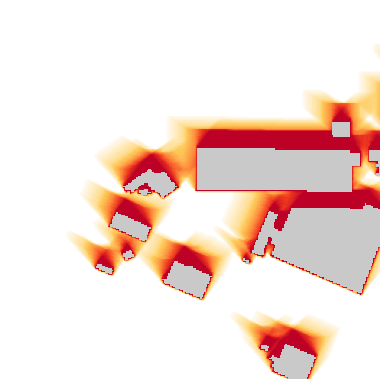

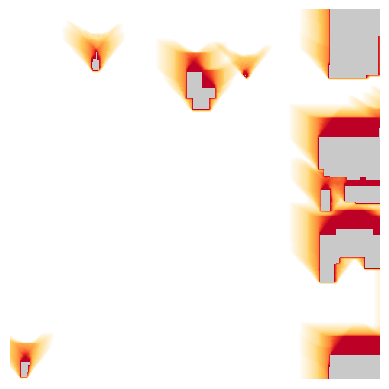

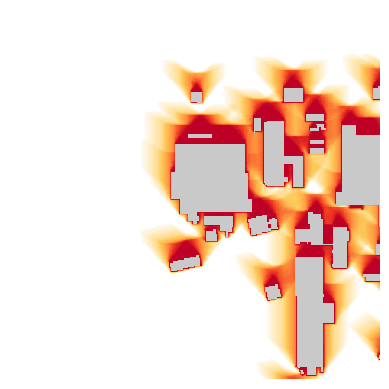

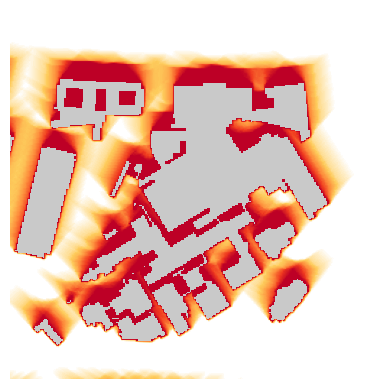

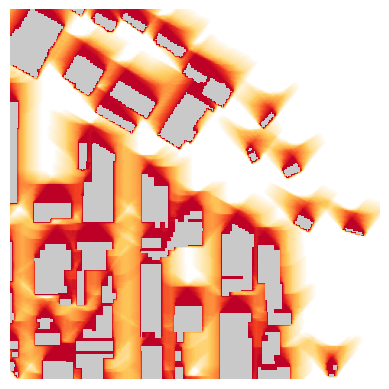

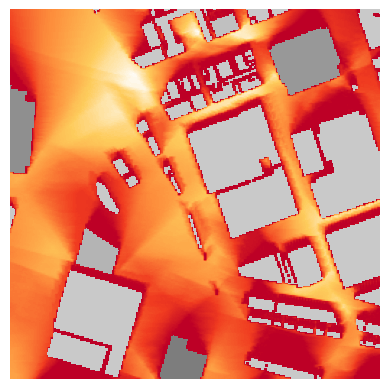

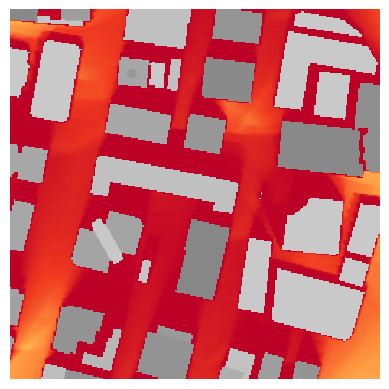

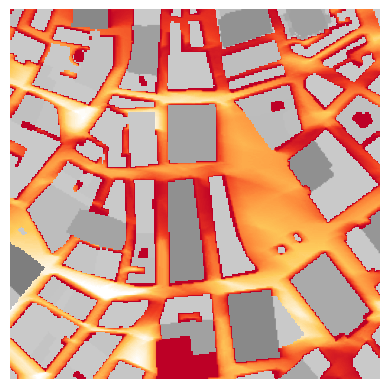

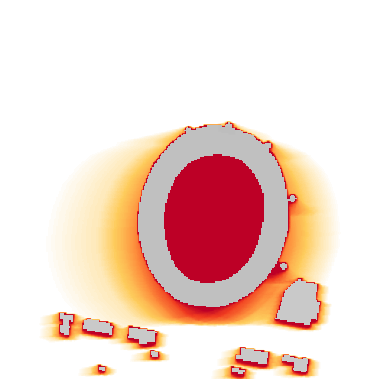

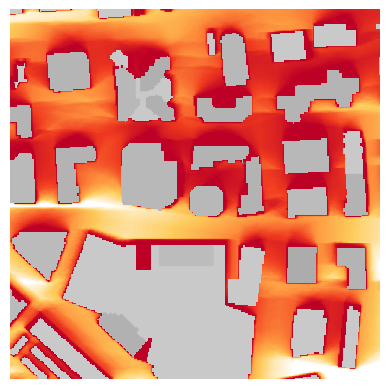

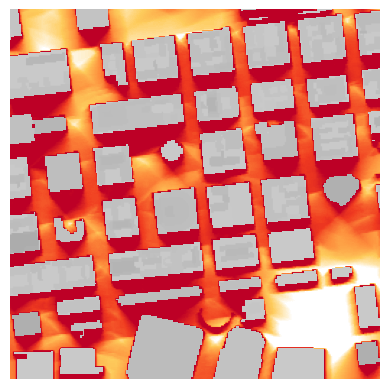

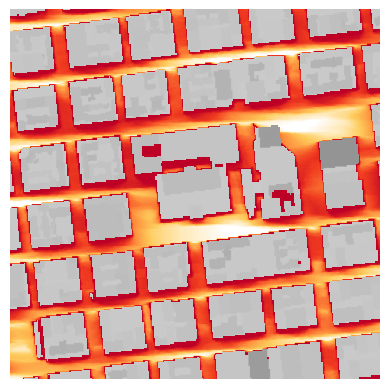

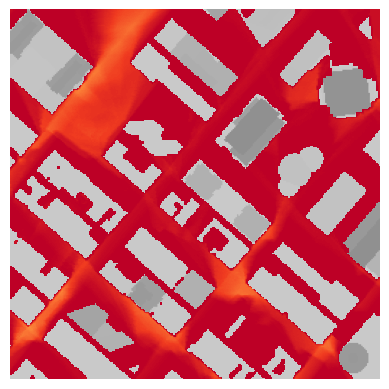

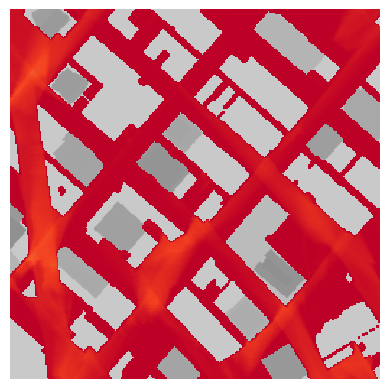

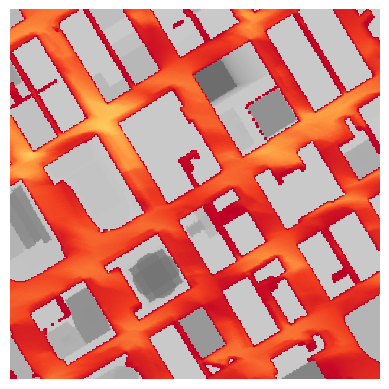

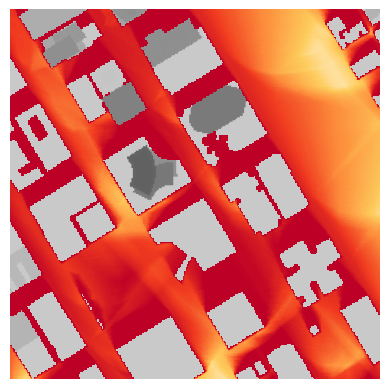

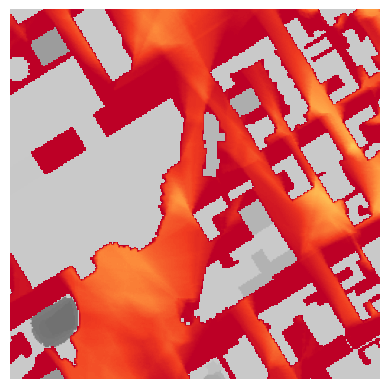

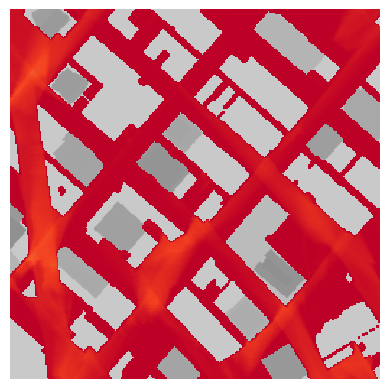

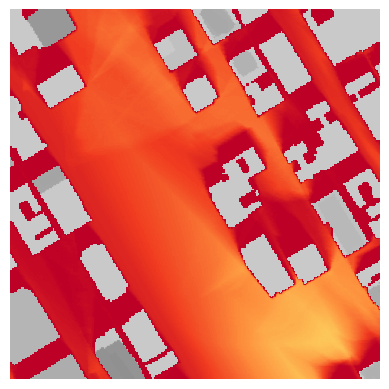

In [10]:
# % bos 19832 24240 summer
# % bue 22127 39476 spring
# % dc 18730 25074 spring
# % joh 37872 37714 winter
# % joh 37873 37713 spring
# % sea 10496 22885 winter
# % sea 10497 22885 winter
# % sea 10497 22887 summer
# % tok 58211 25805 winter
# sea 10498 22888 winter
# tok 58212 25805 winter
# sea 10498 22886 winter
# sea 10497 22885 winter
# sea 10498 22887 winter
# sea 10496 22892 winter
# sea 10496 22896 winter
# sea 10493 22893 winter
# sea 10502 22899 winter
# sea 10488 22873 winter

colors = [(1, 1, 1), (254/255,204/255,92/255), (253/255,141/255,60/255), (240/255,59/255,32/255), (189/255,0,38/255)]
_cmap = LinearSegmentedColormap.from_list('colorscale', colors, N=100)

colors = [(0.8, 0.8, 0.8), (0, 0, 0)]
cmap2 = LinearSegmentedColormap.from_list('colorscale', colors, N=256)

# if not exists create folders like ablation_study/bos_19832_24240_summer
ablation = [
            ['sea', 10496, 22892, 'winter'], ['sea', 10496, 22896, 'winter'], ['sea', 10493, 22893, 'winter'], ['sea', 10502, 22899, 'winter'], ['sea', 10488, 22873, 'winter'],
            ['tok', 58212, 25805, 'winter'], ['tok', 58211, 25805, 'winter'], ['bos', 19832, 24240, 'summer'], ['bue', 22127, 39476, 'spring'], ['dc', 18730, 25074, 'spring'], ['joh', 37872, 37714, 'winter'], 
            ['joh', 37873, 37713, 'spring'], ['sea', 10496, 22885, 'winter'], ['sea', 10497, 22885, 'winter'], ['sea', 10497, 22887, 'summer'],
            ['sea', 10498, 22888, 'winter'],  ['sea', 10498, 22886, 'winter'], ['sea', 10497, 22885, 'winter'], ['sea', 10498, 22887, 'winter'],
            ]

# with tqdm
# for i in range(len(ablation)):
for i in tqdm(range(len(ablation))):
    if not os.path.exists('data/ablation_study/%s_%d_%d_%s/'%(ablation[i][0], ablation[i][1], ablation[i][2], ablation[i][3])):
        os.makedirs('data/ablation_study/%s_%d_%d_%s/'%(ablation[i][0], ablation[i][1], ablation[i][2], ablation[i][3]))

    img = cv2.imread("data\\shadows\\%s-%s\\16\\%d\\%d.png"%(ablation[i][0], ablation[i][3], ablation[i][1], ablation[i][2]), cv2.IMREAD_GRAYSCALE)
    height = cv2.imread("data\\heights_new\\%s\\16\\%d\\%d.png"%(ablation[i][0], ablation[i][1], ablation[i][2]), cv2.IMREAD_GRAYSCALE)
    
    v1a = np.ma.masked_array(height, mask=(height <= 0))
    # v1b = np.ma.masked_array(img, mask=(height > 0))
    v1b = img


    fig, ax = plt.subplots()
    ax.axis('off')
    pb = ax.imshow(v1b, cmap=_cmap, vmin=0, vmax=255);
    pa = ax.imshow(v1a, cmap=cmap2, vmin = 0, vmax = 255);

    # plt.savefig('data/ablation_study/%s_%d_%d_%s/ground_truth.png'%(ablation[i][0], ablation[i][1], ablation[i][2], ablation[i][3]), bbox_inches='tight', pad_inches = 0)
    # plt.close();

    saved_models = ['l1', 'l2', 'ssim_l1', 'ssim_sobel_plus_l1', 'ssim_with_sobel']
    loss_functions = [[l1_loss], [l2_loss], [ssim_loss, l1_loss], [ssim_loss, l1_loss, sobel_loss], [ssim_loss, sobel_loss]]

    for j in range(len(saved_models)):
        tf.keras.backend.clear_session()
        down_stack, up_stack = get_generator_arch('resnet9', attn=False)
        deep_shadow = DeepShadow(512, 512, down_stack, up_stack, latitude=True, date=True, loss_funcs=loss_functions[j], type='resnet9', attention=False)
        deep_shadow.restore('training_checkpoints_new/uniform_cities_resnet_wo_attn__%s'%saved_models[j])

        height, pred = predict_shadow(deep_shadow.generator, 'data/heights_new/', ablation[i][0], ablation[i][3], 16, ablation[i][1], ablation[i][2], lat=True, dat=True)
        pred = np.where(height > 0, 1, pred)
        

    #     # pred = (pred + 1) * 127.5
        v1a = np.ma.masked_array(height, mask=(height <= 0))
        # v1b = np.ma.masked_array(pred, mask=(height > 0))
        v1b = pred

        fig, ax = plt.subplots()
        ax.axis('off')
        pb = ax.imshow(v1b, cmap=_cmap, vmin = -1, vmax = 1);
        pa = ax.imshow(v1a, cmap=cmap2, vmin = 0, vmax = 255);


        plt.savefig('data/ablation_study/%s_%d_%d_%s/%s.png'%(ablation[i][0], ablation[i][1], ablation[i][2], ablation[i][3], saved_models[j]), bbox_inches='tight', pad_inches = 0)
        plt.close();
        test_on_image(deep_shadow.generator, 'data/heights_new/', 'data/shadows/', ablation[i][0], ablation[i][3], 16, ablation[i][1], ablation[i][2], lat=True, dat=True,
                      path = 'data/ablation_study/%s_%d_%d_%s/%s_metrics.png'%(ablation[i][0], ablation[i][1], ablation[i][2], ablation[i][3], saved_models[j]),
                    save=True)
        
    
    # # *** #

    tf.keras.backend.clear_session()
    down_stack, up_stack = get_generator_arch('unet', attn=False)
    deep_shadow = DeepShadow(512, 512, down_stack, up_stack, latitude=True, date=True, loss_funcs=[l1_loss], type='unet', attention=False)
    deep_shadow.restore('training_checkpoints_new/uniform_cities_unet_wo_attn__l1')

    height, pred = predict_shadow(deep_shadow.generator, 'data/heights_new/', ablation[i][0], ablation[i][3], 16, ablation[i][1], ablation[i][2], lat=True, dat=True)
    pred = np.where(height > 0, 1, pred)

    # pred = (pred + 1) * 127.5
    v1a = np.ma.masked_array(height, mask=(height <= 0))
    # v1b = np.ma.masked_array(pred, mask=(height > 0))
    v1b = pred

    fig, ax = plt.subplots()
    ax.axis('off')
    pb = ax.imshow(v1b, cmap=_cmap, vmin = -1, vmax = 1);
    pa = ax.imshow(v1a, cmap=cmap2, vmin = 0, vmax = 255);

    plt.savefig('data/ablation_study/%s_%d_%d_%s/unet_l1.png'%(ablation[i][0], ablation[i][1], ablation[i][2], ablation[i][3]), bbox_inches='tight', pad_inches = 0)
    plt.close();

    test_on_image(deep_shadow.generator, 'data/heights_new/', 'data/shadows/', ablation[i][0], ablation[i][3], 16, ablation[i][1], ablation[i][2], lat=True, dat=True,
                  path = 'data/ablation_study/%s_%d_%d_%s/unet_l1_metrics.png'%(ablation[i][0], ablation[i][1], ablation[i][2], ablation[i][3]),
                save=True)

In [ ]:
def get_generator(_loss_functions, _saved_model, gen_arch='resnet9'):
    tf.keras.backend.clear_session()
    down_stack, up_stack = get_generator_arch(gen_arch, attn=False)
    deep_shadow = DeepShadow(512, 512, down_stack, up_stack, latitude=True, date=True, loss_funcs=_loss_functions, type=gen_arch, attention=False)
    deep_shadow.restore('training_checkpoints_new/%s'%_saved_model)

    return deep_shadow.generator

def get_rmse_list(tiles, gen, city, shadow_path, height_path):
    rmses = []
    for index, row in tqdm(tiles.iterrows(), total=tiles.shape[0], leave=False):
        # get i, j
        i = int(row['i'])
        j = int(row['j'])

        seasons = ['summer', 'winter', 'spring']
        rmse = 0
        for season in seasons:

            # generator, height_path, city, date, zoom, i, j, lat=True, dat=True
            height, pred = predict_shadow(gen, 'data/heights_new/', city, season, 16, i, j, lat=True, dat=True)
            pred = np.where(height > 0, -1, pred)

            gt = load_ground_truth(height, shadow_path, city, season, 16, i, j)
            gt = np.where(height > 0, -1, gt)

            pred = pred*0.5 + 0.5
            gt = gt*0.5 + 0.5

            rmse += np.sqrt(np.mean((pred - gt)**2))
                    
        rmse /= 3
        rmses.append(rmse)

    return rmses

In [ ]:
test_cities = ['dc', 'nyc', 'joh', 'bue', 'bos', 'sea', 'tok']

for file in tqdm(files, total=len(files), leave=False):
    file = file.replace('\\','/')
    tiles = pd.read_csv(file)
    city = file.split('/')[-1].split('.')[0].split('-')[0]

    if city not in test_cities:
        continue

    # print(city)

    # saved_models = ['l2', 'ssim_l1', 'ssim_with_sobel']
    # loss_functions = [[l2_loss], [ssim_loss, l1_loss], [ssim_loss, sobel_loss]]


    # for k in tqdm(range(len(saved_models))):
    #     _saved_model = 'uniform_cities_resnet_wo_attn__%s'%saved_models[k]
    #     gen = get_generator(loss_functions[k], _saved_model, gen_arch='resnet9')

    #     rmses = get_rmse_list(tiles, gen, city, shadow_path, height_path)
        
    #     # print(rmses)
    #     tiles['%s'%saved_models[k]] = rmses
        
    #     tiles.to_csv(file, index=False)

    # gen = get_generator([l1_loss], 'uniform_cities_unet_wo_attn__l1', gen_arch='unet')
    # rmses = get_rmse_list(tiles, gen, city, shadow_path, height_path)
    # tiles['unet_l1'] = rmses
    # tiles.to_csv(file, index=False)

    # gen = get_generator([l1_loss], 'uniform_cities_resnet_wo_attn__l1', gen_arch='resnet9')
    # rmses = get_rmse_list(tiles, gen, city, shadow_path, height_path)
    # tiles['resnet_l1'] = rmses
    # tiles.to_csv(file, index=False)

    gen = get_generator([l1_loss], 'uniform_cities_resnet_wo_attn__ssim_sobel_plus_l1', gen_arch='resnet9')
    rmses = get_rmse_list(tiles, gen, city, shadow_path, height_path)
    tiles['resnet_ssim_sobel_l1'] = rmses
    tiles.to_csv(file, index=False)


In [ ]:
resnet_unet_compare = []
resnet_ssim_sobel_l1_compare = []
for file in files:
    file = file.replace('\\','/')
    tiles = pd.read_csv(file)

    
    for tile in tqdm(range(tiles.shape[0]), total=tiles.shape[0], leave=False):
        i = int(tiles.iloc[tile]['i'])
        j = int(tiles.iloc[tile]['j'])
        city = file.split('/')[-1].split('.')[0].split('-')[0]

        # print(i, j, city)
        # Find if resnet_l1 is better than unet_l1
        if tiles.iloc[tile]['resnet_l1'] < tiles.iloc[tile]['unet_l1']:
            diff = tiles.iloc[tile]['unet_l1'] - tiles.iloc[tile]['resnet_l1']
            resnet_unet_compare.append([city, i, j, diff])

        
        # Find if resnet_ssim_sobel_l1 is better than all: resnet_l1, l2, ssim_l1, ssim_with_sobel
        min_of = min(tiles.iloc[tile]['resnet_l1'], tiles.iloc[tile]['l2'], tiles.iloc[tile]['ssim_l1'], tiles.iloc[tile]['ssim_with_sobel'])
        if tiles.iloc[tile]['resnet_ssim_sobel_l1'] < min_of:
            diff = min_of - tiles.iloc[tile]['resnet_ssim_sobel_l1']
            resnet_ssim_sobel_l1_compare.append([city, i, j, diff])
    

In [ ]:
# create dataframe
resnet_unet_compare = pd.DataFrame(resnet_unet_compare, columns=['city', 'i', 'j', 'diff'])
resnet_ssim_sobel_l1_compare = pd.DataFrame(resnet_ssim_sobel_l1_compare, columns=['city', 'i', 'j', 'diff'])

In [ ]:
# take top 50 values by diff and plot them for all models side by side
colors = [(1, 1, 1), (254/255,204/255,92/255), (253/255,141/255,60/255), (240/255,59/255,32/255), (189/255,0,38/255)]
_cmap = LinearSegmentedColormap.from_list('colorscale', colors, N=100)

def get_image_rmse(gen, city, shadow_path, i, j):
    height, pred = predict_shadow(gen, 'data/heights_new/', city, 'winter', 16, i, j, lat=True, dat=True)
    pred = np.where(height > 0, -1, pred)
    gt = load_ground_truth(height, shadow_path, city, 'winter', 16, i, j)
    gt = np.where(height > 0, -1, gt)

    pred = pred*0.5 + 0.5
    gt = gt*0.5 + 0.5

    rmse = np.sqrt(np.mean((pred - gt)**2))

    return height, gt, pred, rmse

# top_50_to_100 = resnet_ssim_sobel_l1_compare.sort_values(by=['diff'], ascending=False)[50:100]

# spring
# nyc 19295 24640

# summer
# nyc 19299 24623

# create dataframe (winter)
df = pd.DataFrame([['nyc', 19295, 24640], ['nyc', 19297, 24629], ['sea', 10496, 22892], ['sea', 10496, 22896], ['sea', 10493, 22893], ['sea', 10502, 22899], ['sea', 10488, 22873]], columns=['city', 'i', 'j'])

saved_models = ['l1', 'l2', 'ssim_l1', 'ssim_with_sobel', 'ssim_sobel_plus_l1']
loss_functions = [[l1_loss], [l2_loss], [ssim_loss, l1_loss], [ssim_loss, sobel_loss], [ssim_loss, sobel_loss, l1_loss]]
for index, row in tqdm(df.iterrows(), total=df.shape[0], leave=False):
    
    i = int(row['i'])
    j = int(row['j'])
    city = row['city']
    print(city, i, j)

    for k in range(len(saved_models)):
        gen = get_generator(loss_functions[k], 'uniform_cities_resnet_wo_attn__%s'%saved_models[k], gen_arch='resnet9')
        height, gt, pred, rmse = get_image_rmse(gen, city, shadow_path, i, j)

        # gt one time only
        if k == 0:
            plt.figure(figsize=(15, 15))
            plt.subplot(1, 6, 1)
            plt.axis('off')
            plt.imshow(gt, cmap=_cmap);

        plt.subplot(1, 6, k+2)
        plt.axis('off')
        plt.imshow(pred, cmap=_cmap);
        plt.title('%s\nRMSE: %.4f'%(saved_models[k], rmse))

    # plt.show()
    filepath = 'data/ablation_study/new'
    if(not os.path.exists(filepath)):
        os.makedirs(filepath)

    plt.savefig('%s/%s_%d_%d_%s.png'%(filepath, city, i, j, 'winter'), bbox_inches='tight', pad_inches = 0)
    


In [ ]:
# ssim_sobel_plus_l1 best -> test cases
# generate the images using above code. highlight the region. Ask for professor's opinion

# winter
# nyc 19295 24640
# nyc 19297 24629
# sea 10496 22892 **
# sea 10496 22896 **
# sea 10493 22893 **
# sea 10502 22899 **
# nyc 10488 22873 **

# spring
# nyc 19295 24640

# summer
# nyc 19299 24623

In [ ]:
# top_50 = resnet_unet_compare.sort_values(by=['diff'], ascending=False)[:50]

# winter
# sea 10498 22888
# tok 58212 25805
# sea 10498 22886
# sea 10497 22885
# sea 10498 22887

df = pd.DataFrame([['sea', 10498, 22888], ['tok', 58212, 25805], ['sea', 10498, 22886], ['sea', 10497, 22885], ['sea', 10498, 22887]], columns=['city', 'i', 'j'])

for index, row in tqdm(df.iterrows(), total=df.shape[0], leave=False):
    
    i = int(row['i'])
    j = int(row['j'])
    city = row['city']
    print(city, i, j)

    gen = get_generator([l1_loss], 'uniform_cities_unet_wo_attn__l1', gen_arch='unet')
    height, gt, pred, rmse = get_image_rmse(gen, city, shadow_path, i, j)

    plt.figure(figsize=(15, 15))
    plt.subplot(1, 6, 1)
    plt.axis('off')
    plt.imshow(gt, cmap=_cmap)

    plt.subplot(1, 6, 2)
    plt.axis('off')
    plt.imshow(pred, cmap=_cmap);
    plt.title('Unet L1\nRMSE: %.4f'%(rmse))

    gen = get_generator([l1_loss], 'uniform_cities_resnet_wo_attn__l1', gen_arch='resnet9')
    height, gt, pred, rmse = get_image_rmse(gen, city, shadow_path, i, j)

    
    plt.subplot(1, 6, 3)
    plt.axis('off')
    plt.imshow(pred, cmap=_cmap);
    plt.title('ResNet L1\nRMSE: %.4f'%(rmse))
    
    filepath = 'data/ablation_study/new_res_unet'
    if(not os.path.exists(filepath)):
        os.makedirs(filepath)

    plt.savefig('%s/%s_%d_%d_%s.png'%(filepath, city, i, j, 'winter'), bbox_inches='tight', pad_inches = 0)



In [ ]:
# winter
# sea 10498 22888
# tok 58212 25805
# sea 10498 22886
# sea 10497 22885
# sea 10498 22887

In [ ]:
# sea 10496 22892
# sea 10493 22893